# Initial setting

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import functools
import pickle

import imblearn
from imblearn.over_sampling import SMOTE

from scipy import stats
from math import pi

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.7 from "/opt/anaconda3/envs/cs109a/bin/python"
  * The NumPy version is: "1.19.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libopenblas.dylib
  Referenced from: /opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-darwin.so
  Reason: image not found


In [3]:
# create a progressbar function
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [4]:
# common parameters for figures
fig_params = {'legend.fontsize': 'large',
              'figure.figsize': (10, 6),
              'axes.labelsize': 'large',
              'axes.titlesize':'x-large',
              'xtick.labelsize':'large',
              'ytick.labelsize':'large'}
pylab.rcParams.update(fig_params)

# Part A

## Data handling

### create the dataset for Part A

In [5]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

# filter 2020 and 5 clubs (this dataframe is going to be test set)
select_clubs = ['FC Barcelona','FC Bayern München','Real Madrid','Paris Saint-Germain','Juventus','Manchester City','Liverpool']
df_a_2020 = df[(df['year'] == 2020) & (df['club'].isin(select_clubs))]

# filter everything from 2019 (this is going to be training set)
df_a_2019 = df[df['year'] == 2019]

# merge two dataframe
df_a = pd.concat([df_a_2019, df_a_2020]).drop(['d_foot_left'], axis=1)
print(df_a_2020.shape, df_a_2019.shape, df_a.shape)

(221, 146) (17770, 146) (17991, 145)


In [6]:
# create dummies for nationality, work rate, foot
df_a_nationality = pd.get_dummies(df_a[['nationality']], prefix='d_nationality')
df_a_workrate = pd.get_dummies(df_a[['work_rate']], prefix='d_workrate')
df_a_foot = pd.get_dummies(df_a[['preferred_foot']], prefix='d_foot')
df_a_club = pd.get_dummies(df_a[['club']], prefix='d_foot')

# concate them into df_a
df_a = pd.concat([df_a, df_a_nationality, df_a_workrate, df_a_foot, df_a_club], axis=1)
df_a.shape

(17991, 995)

In [7]:
df_a.to_csv('data/df_a.csv', index=False)

### drop columns, imputation, and train-test divide

In [8]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','league_name','main_position','team_jersey_number',
            'club']
df_a_all = df_a.drop(drop_vars, axis=1)

# impute zero values for fieldplayers and goalkeeping ability
# this is because goalkeeping ability is not available for field players and vice versa
impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
impute_vars = impute_vars + [x for x in df_a_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_a_all[var] = df_a_all[var].fillna(0)
    
# impute mean value for ab_mentality_conposure
# Composure is a Player Attribute in FIFA that determines a player's the state or feeling of being calm and 
# controlling their frustration in matches frustration. (from FIFAplay)
df_a_all['ab_mentality_composure'].fillna(df_a_all['ab_mentality_composure'].mean(), inplace=True)

# select players in the following clubs as test set
df_a_te = df_a_all[df_a_all['year'] == 2020].drop(['year'], axis=1)
df_a_tr = df_a_all[df_a_all['year'] == 2019].drop(['year'], axis=1)
print(df_a_tr.shape, df_a_te.shape)

(17770, 979) (221, 979)


## Regression

In [9]:
# assign X and y
X_tr = df_a_tr.drop(['overall'], axis=1)
X_te = df_a_te.drop(['overall'], axis=1)
y_tr = df_a_tr['overall']
y_te = df_a_te['overall']

# standardization
scaler = StandardScaler().fit(X_tr)
X_tr_stan = scaler.transform(X_tr)
X_te_stan = scaler.transform(X_te)

### Lasso regression

In [10]:
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1, 1e+2]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, 
                            X_tr_stan, 
                            y_tr, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 5/5 Done...

18.675537148703818 0.1


In [11]:
lasso_best = Lasso(alpha=la_best_alpha, max_iter=10000)
lasso_best.fit(X_tr_stan, y_tr)

lasso_tr_pred = lasso_best.predict(X_tr_stan)
lasso_te_pred = lasso_best.predict(X_te_stan)

lasso_mse_tr = mean_squared_error(y_tr, lasso_tr_pred)
lasso_mse_te = mean_squared_error(y_te, lasso_te_pred)
print(lasso_mse_tr, lasso_mse_te)

4.945287764552433 7.987019287381537


In [12]:
# save the model to disk
filename = 'models/partA_lasso_best.sav'
pickle.dump(lasso_best, open(filename, 'wb'))

In [13]:
# load the model
filename = 'models/partA_lasso_best.sav'
lasso_best = pickle.load(open(filename, 'rb'))

# calculate evaluation metrics
lasso_te_pred = lasso_best.predict(X_te_stan)
lasso_mse_te = mean_squared_error(y_te, lasso_te_pred)

df_a_lasso = pd.DataFrame({'actual':y_te,
                           'pred':lasso_te_pred})
df_a_lasso['within2'] = np.where(abs(df_a_lasso['actual'] - df_a_lasso['pred']) <= 2, 1, 0)
lasso_prop_within2 = df_a_lasso.within2.describe()['mean'] * 100

# print
print(f'Evaluation metrics - Test MSE: {lasso_mse_te:.2f}, % of obs within +/- 2: {lasso_prop_within2:.1f}')

Evaluation metrics - Test MSE: 7.99, % of obs within +/- 2: 60.2


### Random Forest regression (m=p/3)

In [14]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_tr_stan.shape[1]/3),random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_tr_stan, y_tr)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 114.9min finished


In [15]:
# simple Random Forest regression
rf_tr_pred = rf_best_estimator.predict(X_tr_stan)
rf_te_pred = rf_best_estimator.predict(X_te_stan)

rf_mse_tr = mean_squared_error(y_tr, rf_tr_pred)
rf_mse_te = mean_squared_error(y_te, rf_te_pred)
print(rf_mse_tr, rf_mse_te)

0.102711098021617 0.722307640037196


In [16]:
# save the model to disk
filename = 'models/partA_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

In [17]:
# load the model
filename = 'models/partA_rf_best.sav'
rf_best = pickle.load(open(filename, 'rb'))

# calculate evaluation metrics
rf_te_pred = rf_best.predict(X_te_stan)
rf_mse_te = mean_squared_error(y_te, rf_te_pred)

df_a_rf = pd.DataFrame({'actual':y_te,
                        'pred':rf_te_pred})
df_a_rf['within2'] = np.where(abs(df_a_rf['actual'] - df_a_rf['pred']) <= 2, 1, 0)
rf_prop_within2 = df_a_rf.within2.describe()['mean'] * 100

# print
print(f'Evaluation metrics - Test MSE: {rf_mse_te:.2f}, % of obs within +/- 2: {rf_prop_within2:.1f}')

Evaluation metrics - Test MSE: 0.72, % of obs within +/- 2: 96.4


### XGBoost

In [18]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_tr_stan, y_tr, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [19]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_tr_stan, y_tr)

100%|█████████████████████████████████████████████| 100/100 [1:12:21<00:00, 43.41s/trial, best loss: 8.928813504932943]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9500000000000001,
             gamma=8.055721302386868e-06, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1.2274661445410096,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=0.28671193975173354, reg_lambda=0.00650933174060852,
             scale_pos_weight=1, subsample=0.7000000000000001,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
xgb_tr_pred = xgb_best.predict(X_tr_stan)
xgb_te_pred = xgb_best.predict(X_te_stan)

xgb_mse_tr = mean_squared_error(y_tr, xgb_tr_pred)
xgb_mse_te = mean_squared_error(y_te, xgb_te_pred)
print(xgb_mse_tr, xgb_mse_te)

0.4516870865917849 0.6840630820922725


In [21]:
# save the model to disk
filename = 'models/partA_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

In [22]:
# load the model
filename = 'models/partA_xgb_best.sav'
xgb_best = pickle.load(open(filename, 'rb'))

# calculate evaluation metrics
xgb_te_pred = xgb_best.predict(X_te_stan)
xgb_mse_te = mean_squared_error(y_te, xgb_te_pred)

df_a_xgb = pd.DataFrame({'actual':y_te,
                         'pred':xgb_te_pred})
df_a_xgb['within2'] = np.where(abs(df_a_xgb['actual'] - df_a_xgb['pred']) <= 2, 1, 0)
xgb_prop_within2 = df_a_xgb.within2.describe()['mean'] * 100

# print
print(f'Evaluation metrics - Test MSE: {xgb_mse_te:.2f}, % of obs within +/- 2: {xgb_prop_within2:.1f}')

Evaluation metrics - Test MSE: 0.68, % of obs within +/- 2: 97.7


## Visualization

### Set up

In [23]:
# create a dataset for visualization
df_a_viz = pd.DataFrame({'actual':y_te,
                         'pred_lasso':lasso_te_pred,
                         'pred_rf':rf_te_pred,
                         'pred_xgb':xgb_te_pred})

### Scatter plot for actual vs. prediction

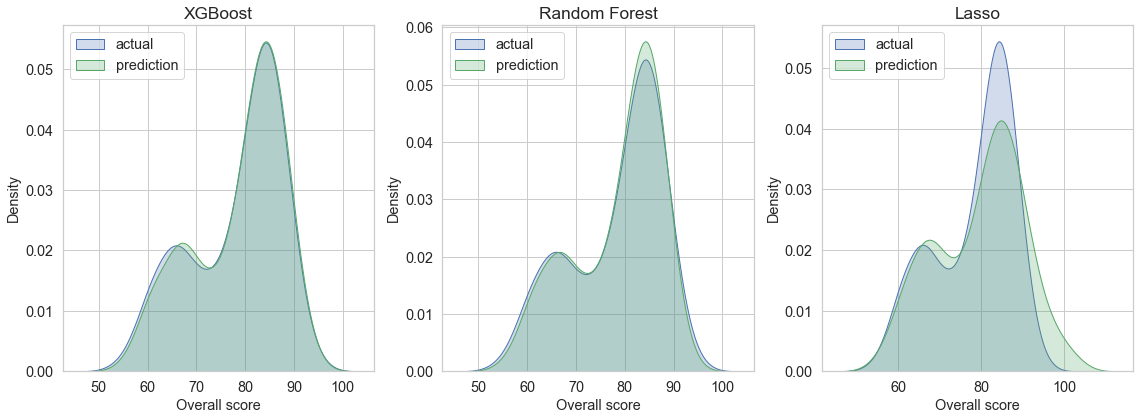

In [24]:
# create a list of predictions
predictions = ['pred_xgb','pred_rf','pred_lasso']
models = ['XGBoost','Random Forest','Lasso']

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, ax in enumerate(axs.ravel()):
    sns.kdeplot(data=df_a_viz,
                x='actual',
                color='b',
                fill='b',
                label='actual',
                ax=ax)
    sns.kdeplot(data=df_a_viz,
                x=predictions[i],
                color='g',
                fill='g',
                label='prediction',
                ax=ax)
    ax.set(xlabel='Overall score',
           title=models[i])
    ax.legend(loc='upper left')
#fig.suptitle('Relationship between actual and predicted scores, by models', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartA_kde_models.png', dpi=300)

# Part C

## Data handling

### create the dataset for Part C

In [25]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

# select players in the following clubs as test set
df_c = df[df['d_div1_league']==1]

# extract league and club
df_league_club = df_c.copy()
df_league_club = df_league_club[['league_name','club']].drop_duplicates()
df_league_club['variable'] = 'club_' + df_league_club['club']

# create lead variables for target variables (values in the following year)
target_vars = ['overall','value_eur','skill_moves','d_multiple_position','d_trait_Injury_Prone']
added_vars = []

df_c = df_c.sort_values(['sofifa_id','year'])
for i, target_var in enumerate(target_vars):
    # insert lead variables next to original ones
    col_index = list(df_c.columns).index(target_var) + 1
    next_var = target_var + '_next'
    diff_var = target_var + '_diff'
    df_c.insert(col_index, next_var, df_c.groupby(['sofifa_id'])[target_var].shift(-1))
    
    # calculate change to the following years
    # for value, calculate percentage change as distribution is highly skewed
    if target_var == 'value_eur':
        df_c.insert(col_index + 1, diff_var, np.log(df_c[next_var]) - np.log(df_c[target_var]))
    else:
        df_c.insert(col_index + 1, diff_var, df_c[next_var] - df_c[target_var])
        
    added_vars.append(next_var)
    added_vars.append(diff_var)

# create dummies for club, nationality, 
df_c_dummies = pd.get_dummies(df_c[['nationality','club','work_rate','league_name']])
df_c = pd.concat([df_c, df_c_dummies], axis=1)

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### drop columns, imputation

In [26]:
df_c.to_csv('data/df_c.csv', index=False)

In [27]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','club','wage_eur','preferred_foot','work_rate','body_type',
             'team_position','team_jersey_number','joined','contract_valid_until','league_name','release_clause_eur',
             'loaned_from','main_position','year']
df_c_all = df_c.drop(drop_vars, axis=1)

# impute zero values for fieldplayers and goalkeeping ability
# this is because goalkeeping ability is not available for field players and vice versa
impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic'] + [x for x in df_c_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_c_all[var] = df_c_all[var].fillna(0)
    
# impute mean value for ab_mentality_conposure
# Composure is a Player Attribute in FIFA that determines a player's the state or feeling of being calm and 
# controlling their frustration in matches frustration. (from FIFAplay)
df_c_all['ab_mentality_composure'].fillna(df_c_all['ab_mentality_composure'].mean(), inplace=True)

# save to csv
df_c_all.to_csv('data/df_c_all.csv', index=False)

## Regression

Basic idea  
- We define a club's ability to increase a player stats and value as the club's performance when we control the player's basic characteristics, e.g. age, reputation, skills, etc. 
- Given this, we regress players' overall score (annual change) on all these characteristics and club dummies, and identify the feature importance of a club dummy as the club's performance when controlling other factors.

### Overall score

#### Filter data, standardization, etc.

In [28]:
# separate a dataset for overall score regression and drop NA
section_target = 'overall'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_ovr = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_ovr = df_c_ovr.drop('value_eur', axis=1)
df_c_ovr = df_c_ovr.dropna()

# save to csv
df_c_ovr.to_csv('data/df_c_ovr.csv', index=False)
df_c_ovr.shape

(10517, 361)

In [29]:
# assign X and y
X = df_c_ovr.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_ovr[section_target + '_diff']

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### LASSO

In [30]:
# grid search
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 4/4 Done...

6.743067001152627 0.01


In [31]:
# refit Lasso using best alpha
la_best = Lasso(alpha=la_best_alpha, max_iter=10000)
la_best.fit(X_stan, y)

# store coefficients into dataframe
df_ovr_la_fi = pd.DataFrame({'variable':X.columns,
                             'ovr_la':la_best.coef_})
df_ovr_la_fi = df_ovr_la_fi[df_ovr_la_fi['variable'].str.startswith('club')]

# save the model to disk
filename = 'models/partC_ovr_la_best.sav'
pickle.dump(la_best, open(filename, 'wb'))

#### Random Forest (m=p/3)

In [32]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_stan.shape[1]/3),random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 26.2min finished


In [33]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_ovr_rf_fi = pd.DataFrame({'variable':clubs,
                             'ovr_rf':rf_fi})

# save the model to disk
filename = 'models/partC_ovr_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [34]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [35]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y)

100%|███████████████████████████████████████████████| 100/100 [14:36<00:00,  8.76s/trial, best loss: 6.667907084114356]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.65,
             gamma=0.06737537763833035, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=8.539019477920405,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=0.16836423523146404, reg_lambda=9.890827461835658,
             scale_pos_weight=1, subsample=0.7000000000000001,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_ovr_xgb_fi = pd.DataFrame({'variable':clubs,
                              'ovr_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_ovr_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Market value

#### Filter data, standardization, etc.

In [37]:
# separate a dataset for market value regression and drop NA
section_target = 'value_eur'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_value = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_value = df_c_value.replace([np.inf, -np.inf], np.nan)
df_c_value = df_c_value.dropna()

# save to csv
df_c_value.to_csv('data/df_c_value.csv', index=False)
df_c_value.shape

(8432, 362)

In [38]:
# assign X and y
X = df_c_value.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_value[section_target + '_diff']

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### LASSO

In [39]:
# grid search
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 4/4 Done...

0.3110163303647024 0.01


In [40]:
# refit Lasso using best alpha
la_best = Lasso(alpha=la_best_alpha, max_iter=10000)
la_best.fit(X_stan, y)

# store coefficients into dataframe
df_value_la_fi = pd.DataFrame({'variable':X.columns,
                               'value_la':la_best.coef_})
df_value_la_fi = df_value_la_fi[df_value_la_fi['variable'].str.startswith('club')]

# save the model to disk
filename = 'models/partC_value_la_best.sav'
pickle.dump(la_best, open(filename, 'wb'))

#### Random Forest (m=p/3)

In [41]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_stan.shape[1]/3),random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 21.2min finished


In [42]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_value_rf_fi = pd.DataFrame({'variable':clubs,
                               'value_rf':rf_fi})

# save the model to disk
filename = 'models/partC_value_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [43]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [44]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y)

100%|██████████████████████████████████████████████| 100/100 [12:50<00:00,  7.71s/trial, best loss: 0.3183672646921562]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8500000000000001,
             gamma=0.0023861216083917386, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1.9952861535592965,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=5.628704955261183e-07, reg_lambda=9.81298801419108,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_value_xgb_fi = pd.DataFrame({'variable':clubs,
                                'value_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_value_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Technique

#### Filter data, standardization, etc.

In [46]:
# separate a dataset for overall score regression and drop NA
section_target = 'skill_moves'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_skill = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_skill = df_c_skill.drop('value_eur', axis=1)
df_c_skill = df_c_skill.dropna()

# replace +- 2 -> +-1 since # of observations are too small
df_c_skill[section_target + '_diff'] = df_c_skill[section_target + '_diff'].replace([2, -2], [1, -1])

# save to csv
df_c_skill.to_csv('data/df_c_skill.csv', index=False)
df_c_skill.shape

(10517, 361)

In [47]:
# assign X and y
X = df_c_skill.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_skill[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 15% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.15)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [48]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.3min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  1.6min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.8min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  1.8min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  2.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  3.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  3.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  4.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [49]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_log_fi = pd.DataFrame({'variable':clubs,
                                'skill_log':log_fi})

# save the model to disk
filename = 'models/partC_skill_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [50]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:  7.3min finished


In [51]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_rf_fi = pd.DataFrame({'variable':clubs,
                               'skill_rf':rf_fi})

# save the model to disk
filename = 'models/partC_skill_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [52]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[-1.  0.  1.], y=0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12099    1.0
12100    1.0
12101    1.0
12102    1.0
12103    1.0
Name: skill_moves_diff, Length: 12104, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [53]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|████████████████████████████████████████████| 100/100 [1:14:31<00:00, 44.72s/trial, best loss: 0.8176569684680534]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65,
              gamma=6.584385586089192e-06, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=8.177153951724966,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              random_state=81, reg_alpha=0.03312972253513172,
              reg_lambda=0.002355689443633803, scale_pos_weight=None,
              subsample=0.8500000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [54]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_xgb_fi = pd.DataFrame({'variable':clubs,
                                'skill_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_skill_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Utility

#### Filter data, standardization, etc.

In [55]:
# separate a dataset for overall score regression and drop NA
section_target = 'd_multiple_position'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_util = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_util = df_c_util.drop('value_eur', axis=1)
df_c_util = df_c_util.dropna()

# save to csv
df_c_util.to_csv('data/df_c_util.csv', index=False)
df_c_util.shape

(10517, 361)

In [56]:
# assign X and y
X = df_c_util.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_util[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 20% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.2)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [57]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.2min remaining: 14.5min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.3min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.6min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  2.8min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  3.5min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  4.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  4.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  6.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [58]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_util_log_fi = pd.DataFrame({'variable':clubs,
                               'util_log':log_fi})

# save the model to disk
filename = 'models/partC_util_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [59]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:  7.9min finished


In [60]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_util_rf_fi = pd.DataFrame({'variable':clubs,
                              'util_rf':rf_fi})

# save the model to disk
filename = 'models/partC_util_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [61]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[-1.  0.  1.], y=0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12553    1.0
12554    1.0
12555    1.0
12556    1.0
12557    1.0
Name: d_multiple_position_diff, Length: 12558, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [62]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|████████████████████████████████████████████| 100/100 [1:24:26<00:00, 50.66s/trial, best loss: 0.7544229276533571]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9500000000000001,
              gamma=1.8673618992376526e-05, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=7.721180348987109,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              random_state=81, reg_alpha=3.742052322972517e-06,
              reg_lambda=0.04381075490277451, scale_pos_weight=None,
              subsample=0.65, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [63]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_util_xgb_fi = pd.DataFrame({'variable':clubs,
                               'util_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_util_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Injury Resistance

#### Filter data, standardization, etc.

In [64]:
# separate a dataset for overall score regression and drop NA
section_target = 'd_trait_Injury_Prone'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_injury = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_injury = df_c_injury.drop('value_eur', axis=1)
df_c_injury = df_c_injury.dropna()

# save to csv
df_c_injury.to_csv('data/df_c_injury.csv', index=False)
df_c_injury.shape

(10517, 361)

In [65]:
# assign X and y
X = df_c_injury.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_injury[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 20% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.2)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [66]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.0min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.0min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.3min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  4.0min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  7.2min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  8.1min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  8.3min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  8.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  9.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [109]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = -1*(pred_one - pred_zero)
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_log_fi = pd.DataFrame({'variable':clubs,
                                 'injury_log':log_fi})

# save the model to disk
filename = 'models/partC_injury_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [68]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:  8.6min finished


In [110]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = -1*(pred_one - pred_zero)
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_rf_fi = pd.DataFrame({'variable':clubs,
                                'injury_rf':rf_fi})

# save the model to disk
filename = 'models/partC_injury_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [70]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[-1.  0.  1.], y=0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13789    1.0
13790    1.0
13791    1.0
13792    1.0
13793    1.0
Name: d_trait_Injury_Prone_diff, Length: 13794, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [71]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|██████████████████████████████████████████████| 100/100 [57:18<00:00, 34.39s/trial, best loss: 0.8949571854102112]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001,
              gamma=0.00017709815831700845, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1.006510065517325,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              random_state=81, reg_alpha=2.9164743642572604e-05,
              reg_lambda=0.037174032874054075, scale_pos_weight=None,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [111]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = -1*(pred_one - pred_zero)
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_xgb_fi = pd.DataFrame({'variable':clubs,
                               'injury_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_injury_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

## Merge all feature importance

In [132]:
# merge all dataframes
merge_dfs = [df_ovr_la_fi, df_ovr_rf_fi, df_ovr_xgb_fi,
             df_value_la_fi, df_value_rf_fi, df_value_xgb_fi,
             df_skill_log_fi, df_skill_rf_fi, df_skill_xgb_fi,
             df_util_log_fi, df_util_rf_fi, df_util_xgb_fi,
             df_injury_log_fi, df_injury_rf_fi, df_injury_xgb_fi]
df_c_fi = functools.reduce(lambda  left,right: pd.merge(left,right,on=['variable']), merge_dfs)

# rescale all feature importance
targets = ['ovr', 'value', 'skill', 'util', 'injury']
models = ['la', 'log', 'rf', 'xgb']
all_pattern = []
for target in targets:
    for model in models:
        all_pattern.append(target + '_' + model)

rescale_scores = []
for pattern in all_pattern:
    try:
        df_c_fi[pattern + '_rescale'] = MinMaxScaler().fit_transform(df_c_fi[[pattern]]) * 100
        rescale_scores.append(pattern + '_rescale')
    except:
        continue

# mean of each section
for target in targets:
    section_scores = [x for x in rescale_scores if x.startswith(target)]
    df_c_fi[target + '_mean'] = df_c_fi[section_scores].mean(axis=1)
    df_c_fi[target + '_mean'] = MinMaxScaler().fit_transform(df_c_fi[[target + '_mean']]) * 100

# calculate mean of all scores 
df_c_fi['all_mean'] = df_c_fi[rescale_scores].mean(axis=1)

# merge league name
df_c_fi = df_c_fi.merge(df_league_club, on='variable')
df_c_fi = df_c_fi.sort_values(['league_name','all_mean'], ascending=False)
df_c_fi.to_csv('data/df_c_fi.csv', index=False)

## Visualization

To do  
- radar chart by league
- radar chart for top 3 vs bottom 3 teams
- distribution for each indicator

### Set up

In [134]:
# read dataset
df_c_viz = pd.read_csv('data/df_c_fi.csv')

# list of 5 indicators
sub_scores = ['Overall score','Market value','Technique','Utility','Injury resistance']
sub_scores_label = ['Player overall score','Market\nvalue','Technique','Utility','Injury\nresistance']

# select columns
df_c_viz = df_c_viz[['ovr_mean','value_mean','skill_mean','util_mean','injury_mean','all_mean','league_name','club']]
df_c_viz.columns = sub_scores + ['Total score','league','club']
df_c_viz = df_c_viz.sort_values('Total score', ascending=False)

In [135]:
df_c_viz.describe()

,Overall score,Market value,Technique,Utility,Injury resistance,Total score
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,38.318454,46.740047,58.656450,35.156489,55.149813,48.208502
std,13.610311,12.925587,17.285650,15.864666,12.798460,6.873082
min,0.000000,0.000000,0.000000,0.000000,0.000000,28.410835
25%,32.612610,43.865557,50.371405,25.470552,49.254947,43.857344
50%,39.556234,47.220084,58.994219,32.861179,53.520895,48.390834
75%,43.380452,50.583886,68.243581,39.028800,62.124999,52.132078
max,100.000000,100.000000,100.000000,100.000000,100.000000,70.920362


In [136]:
# create a function for radar chart
def make_radar(df, i, ax, target):
    
    if i + 1 > len(df):
        ax.set_visible(False)

    else:
        # number of variable
        N = len(sub_scores)

        # angle of axises
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # initiate a radar plot
        ax = plt.subplot(2, 3, i+1, polar=True)

        # rotate so that the first category is placed at top
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], sub_scores_label, color='grey', size=13)

        # draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([20,40,60,80,100], ['20','40','60','80','100'], color="grey", size=9)
        plt.ylim(0,100)

        # create a list of values for each club
        values=df.loc[i][sub_scores].values.flatten().tolist()    
        values += values[:1] 
        ax.plot(angles, values, color=my_palette(i), linewidth=2, linestyle='solid')
        ax.fill(angles, values, color=my_palette(i), alpha=0.4)

        # Add a title
        plt.title(df[target][i] + f' ({df["Total score"][i]:.1f})', size=14)

### Top 3 vs Bottom 3

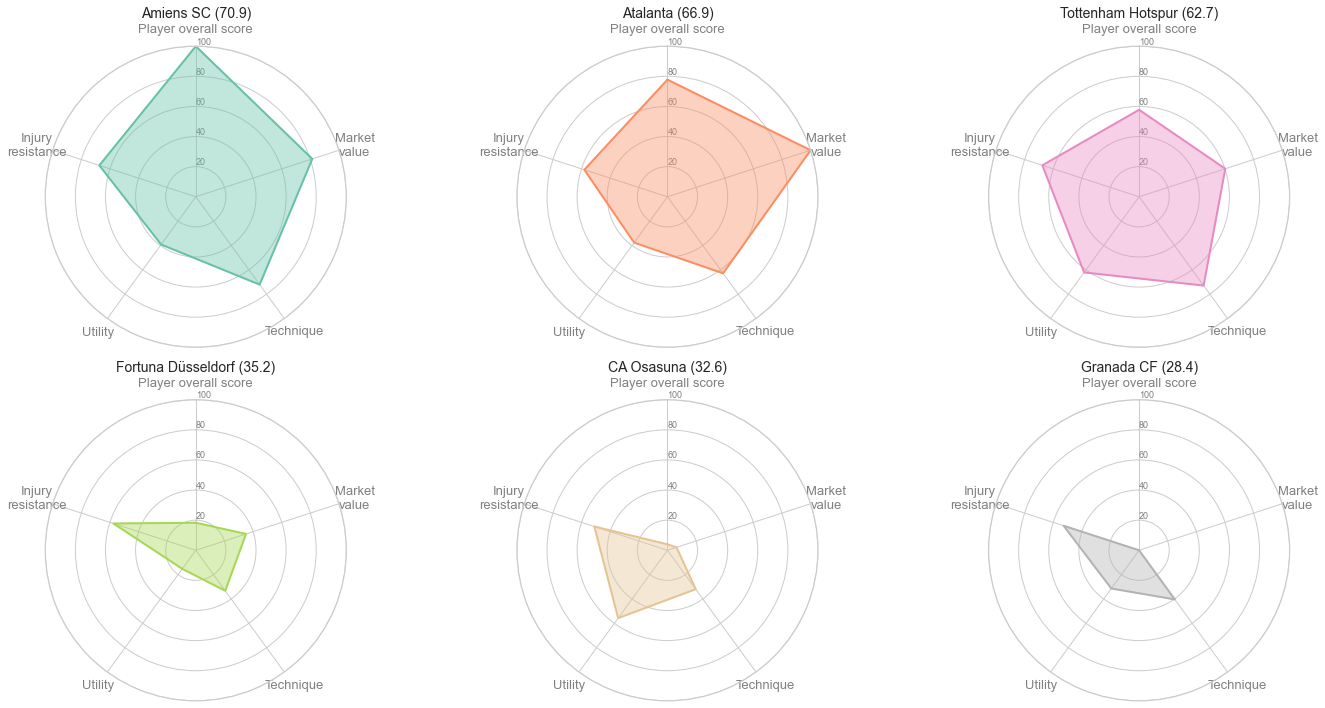

In [137]:
# select top 3 and bottom 3 clubs
df_c_viz_topbottom = pd.concat([df_c_viz.head(3), df_c_viz.tail(3)]).reset_index()

# initialize the figure
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_topbottom.index))
for i, ax in enumerate(axs.ravel()):
    make_radar(df=df_c_viz_topbottom, i=i, ax=ax, target='club')
#fig.suptitle('Top 3 clubs vs. Bottom 3 clubs', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_top3-bottom3.png', dpi=300)

### League average

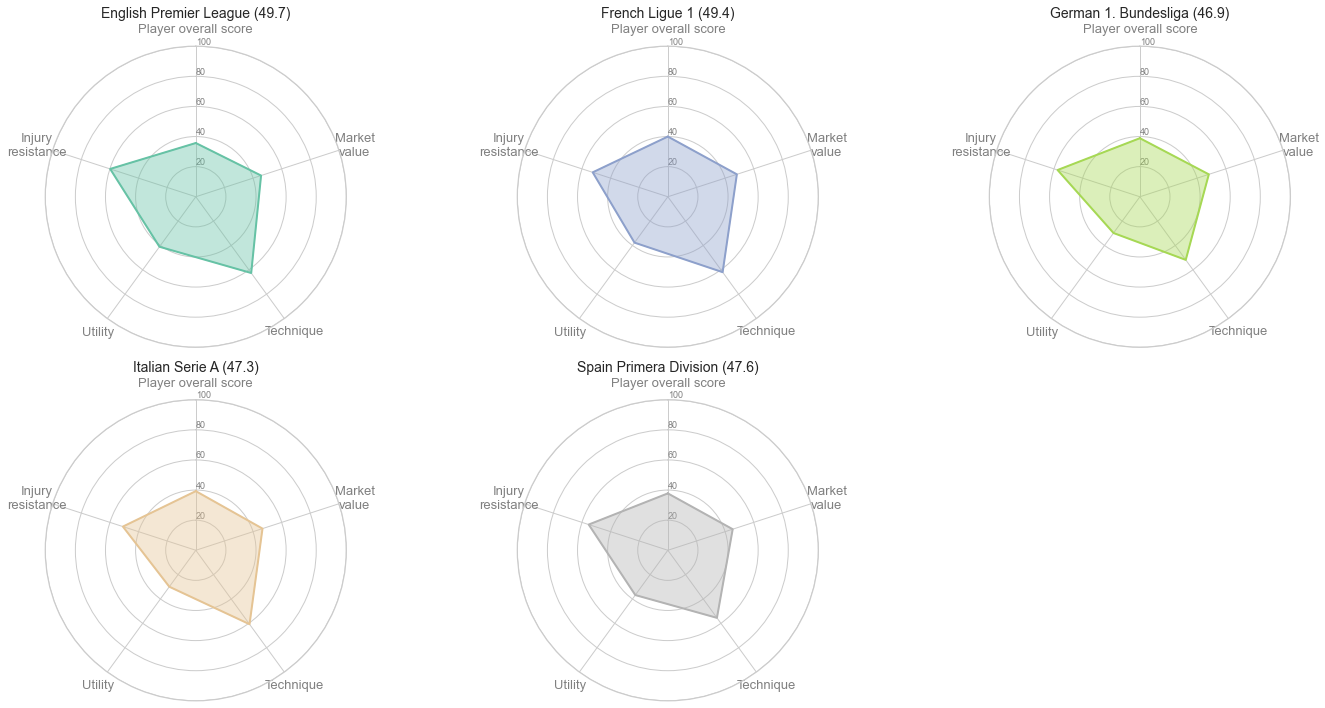

In [156]:
# select top 3 and bottom 3 clubs
df_c_viz_league = df_c_viz.drop(['club'],axis=1).groupby('league', as_index=False).mean()

# initialize the figure
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    make_radar(df=df_c_viz_league, i=i, ax=ax, target='league')
#fig.suptitle('League average', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_leagure-average.png', dpi=300)

### Distribution of each score, by leagues

In [139]:
# set leagues
leagues = ['English Premier League','French Ligue 1','German 1. Bundesliga','Italian Serie A','Spain Primera Division']

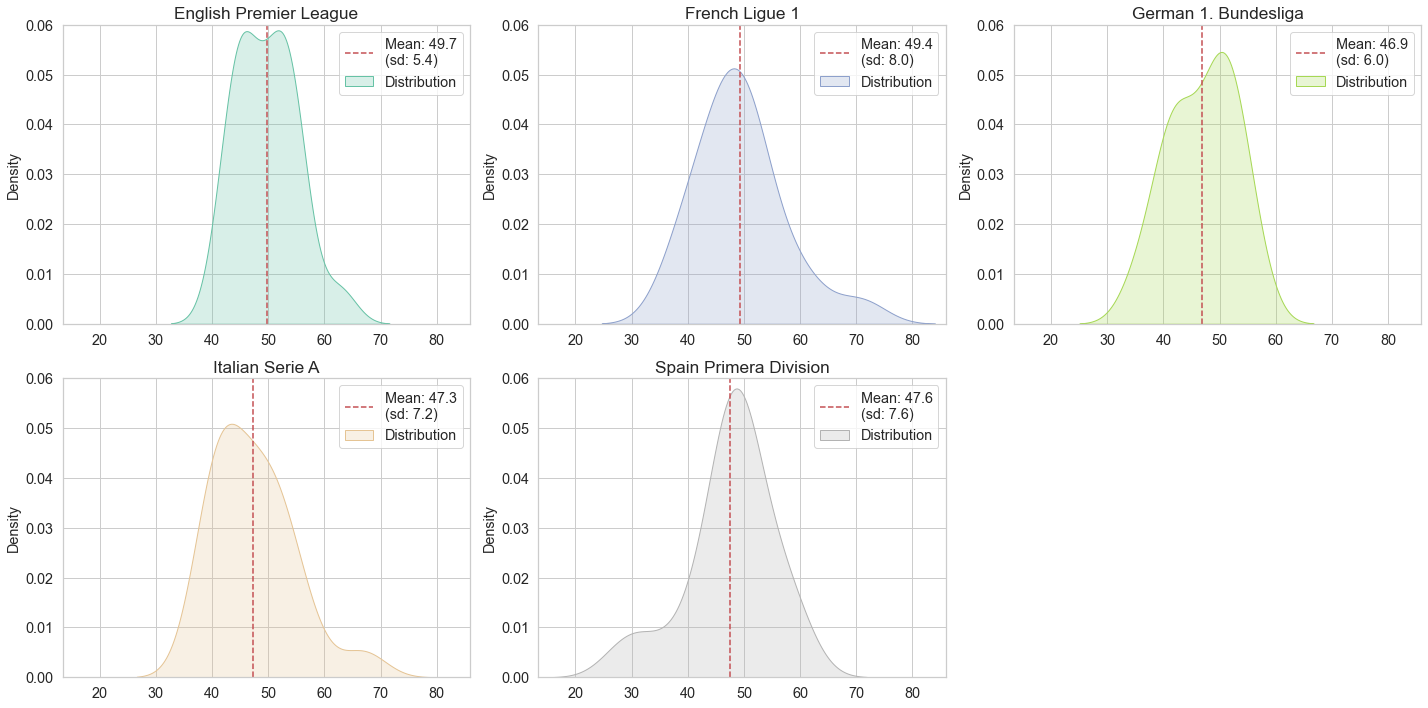

In [173]:
# Total score
xmin = max(df_c_viz['Total score'].min() - 10, 0)
xmax = min(df_c_viz['Total score'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Total score', 
                    color=my_palette(i),                     
                    fill=my_palette(i),                     
                    label='Distribution',
                    ax=ax)
        ax.axvline(x=df_league['Total score'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Total score"].mean():.1f}\n(sd: {df_league["Total score"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.06)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Total score, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_total-score.png', dpi=300)

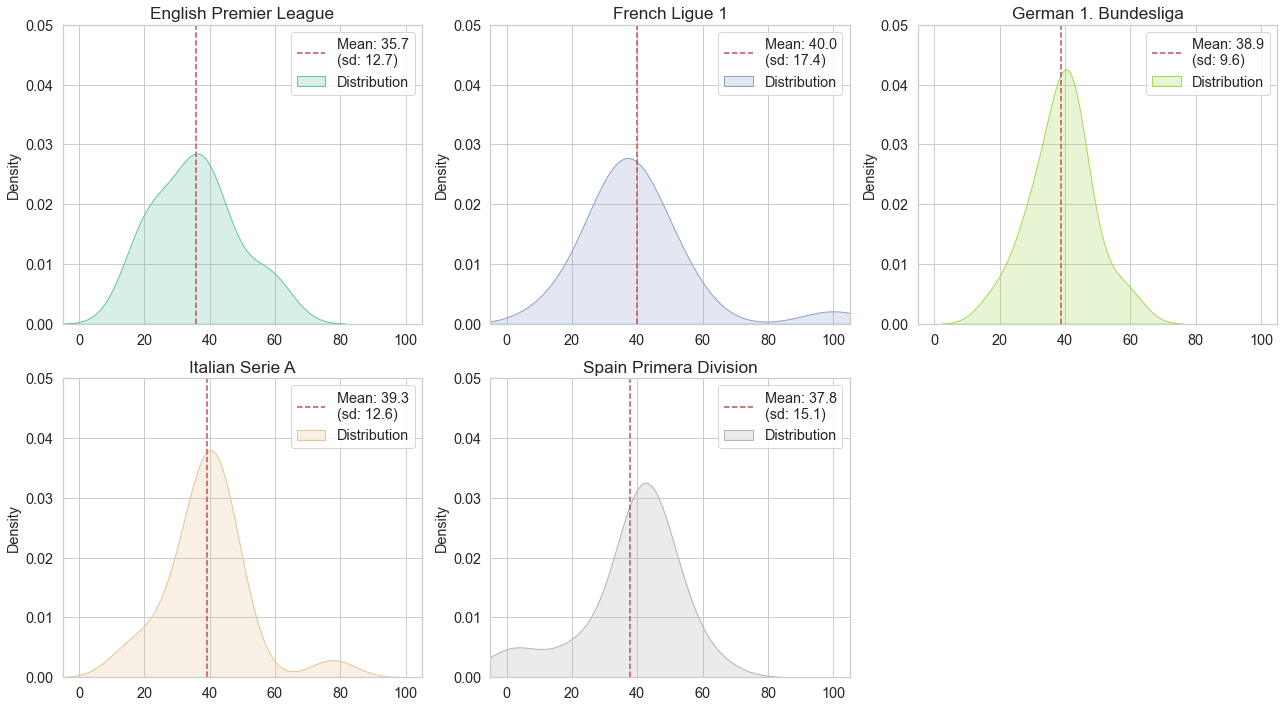

In [174]:
# Overall score
xmin = max(df_c_viz['Overall score'].min() - 10, 0)
xmax = min(df_c_viz['Overall score'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Overall score',
                    color=my_palette(i),                     
                    fill=my_palette(i),                     
                    label='Distribution',                     
                    ax=ax)
        ax.axvline(x=df_league['Overall score'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Overall score"].mean():.1f}\n(sd: {df_league["Overall score"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.05)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Overall score, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_ovr.png', dpi=300)

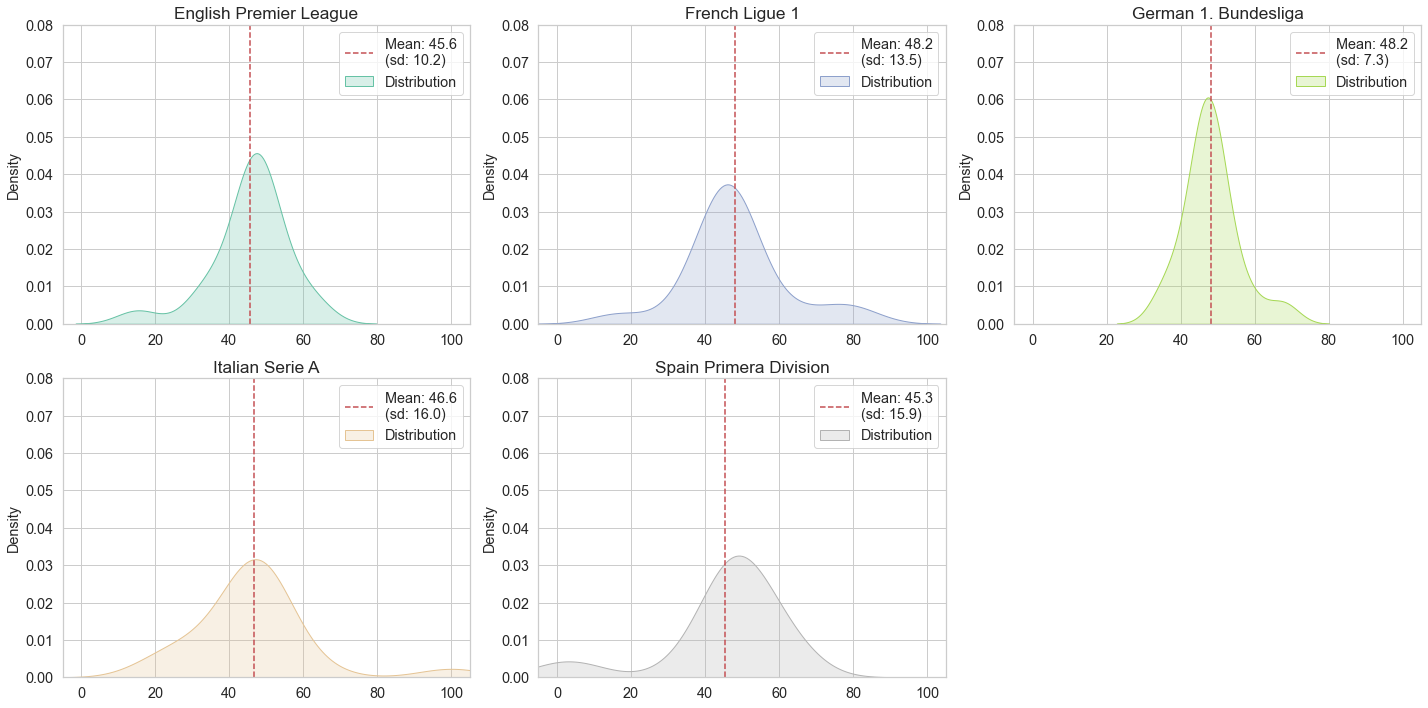

In [175]:
# Market value
xmin = max(df_c_viz['Market value'].min() - 10, 0)
xmax = min(df_c_viz['Market value'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Market value', 
                    color=my_palette(i),
                    fill=my_palette(i),                     
                    label='Distribution',
                    ax=ax)
        ax.axvline(x=df_league['Market value'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Market value"].mean():.1f}\n(sd: {df_league["Market value"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.08)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Market value, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_value.png', dpi=300)

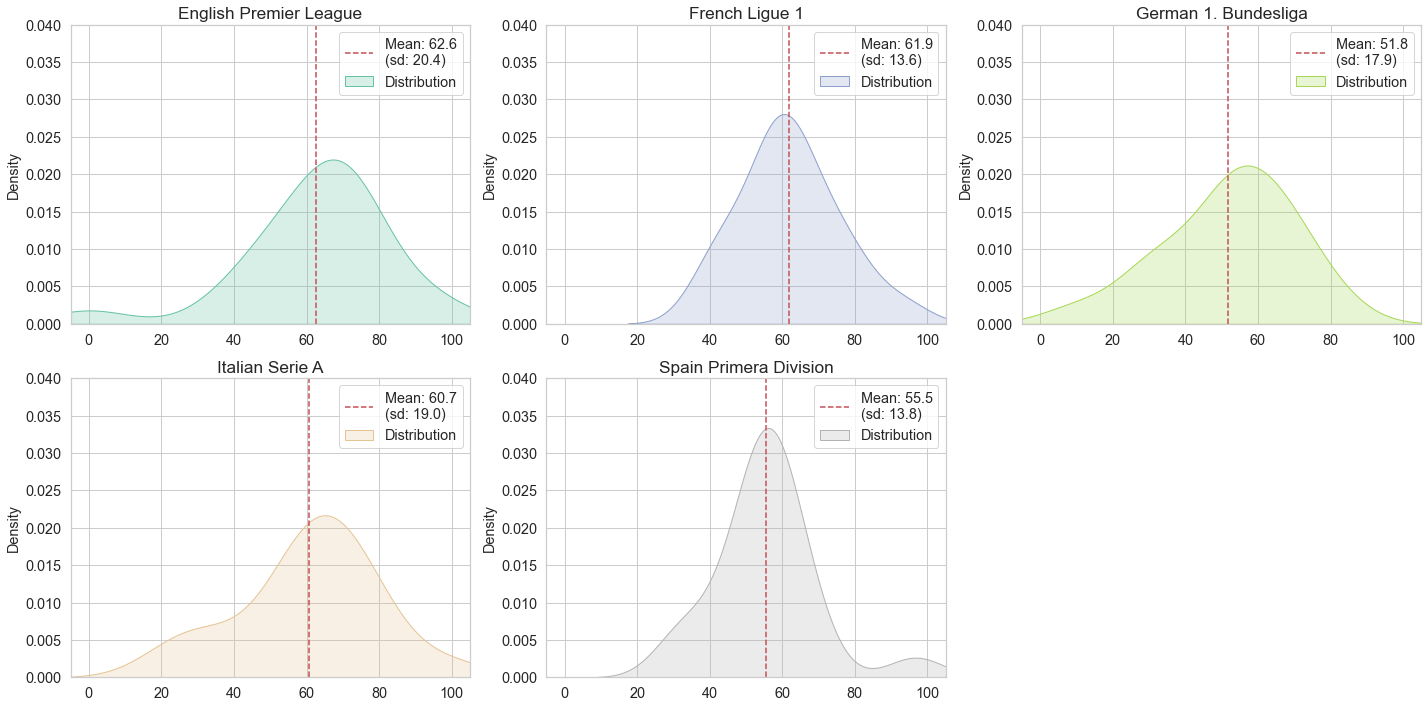

In [176]:
# Technique
xmin = max(df_c_viz['Technique'].min() - 10, 0)
xmax = min(df_c_viz['Technique'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Technique',
                    color=my_palette(i),
                    fill=my_palette(i),                     
                    label='Distribution',
                    ax=ax)
        ax.axvline(x=df_league['Technique'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Technique"].mean():.1f}\n(sd: {df_league["Technique"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.04)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Technique, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_skill.png', dpi=300)

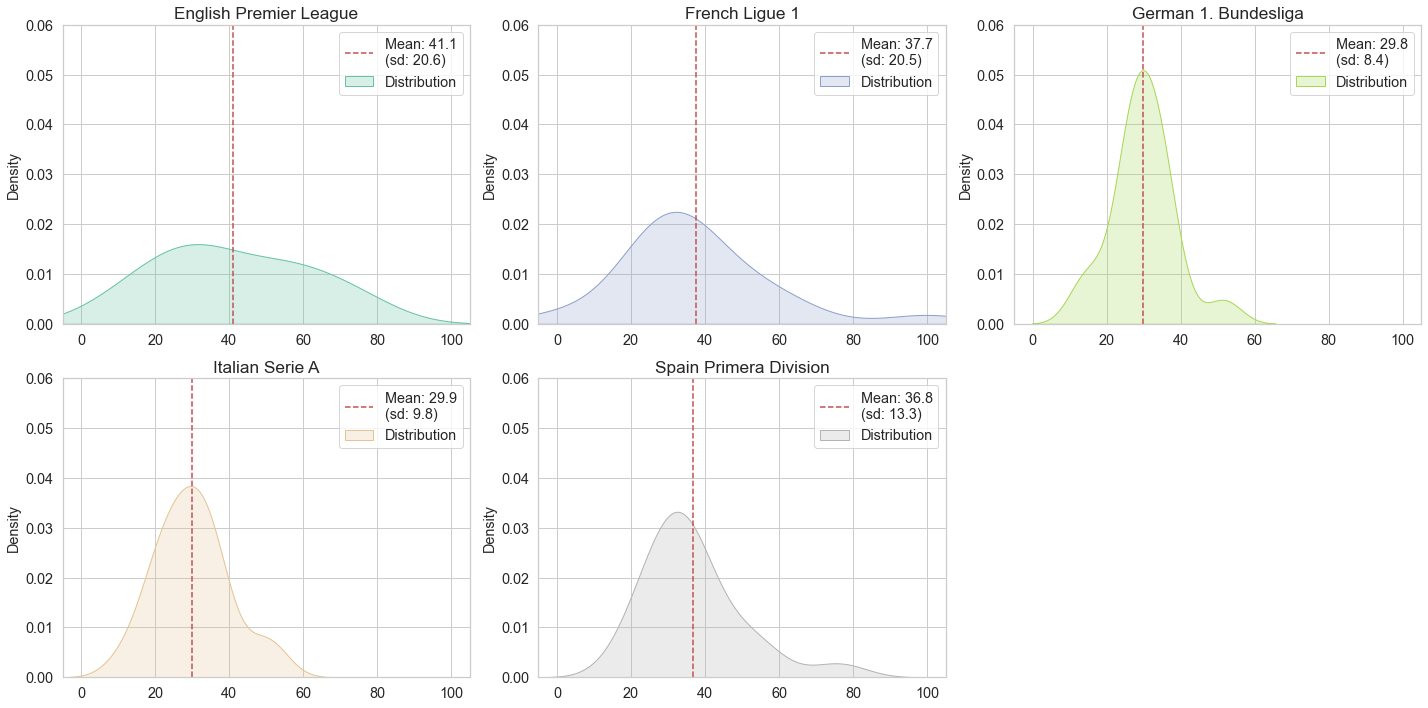

In [177]:
# Utility
xmin = max(df_c_viz['Utility'].min() - 10, 0)
xmax = min(df_c_viz['Utility'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Utility', 
                    color=my_palette(i), 
                    fill=my_palette(i),                     
                    label='Distribution', 
                    ax=ax)
        ax.axvline(x=df_league['Utility'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Utility"].mean():.1f}\n(sd: {df_league["Utility"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.06)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Utility, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_util.png', dpi=300)

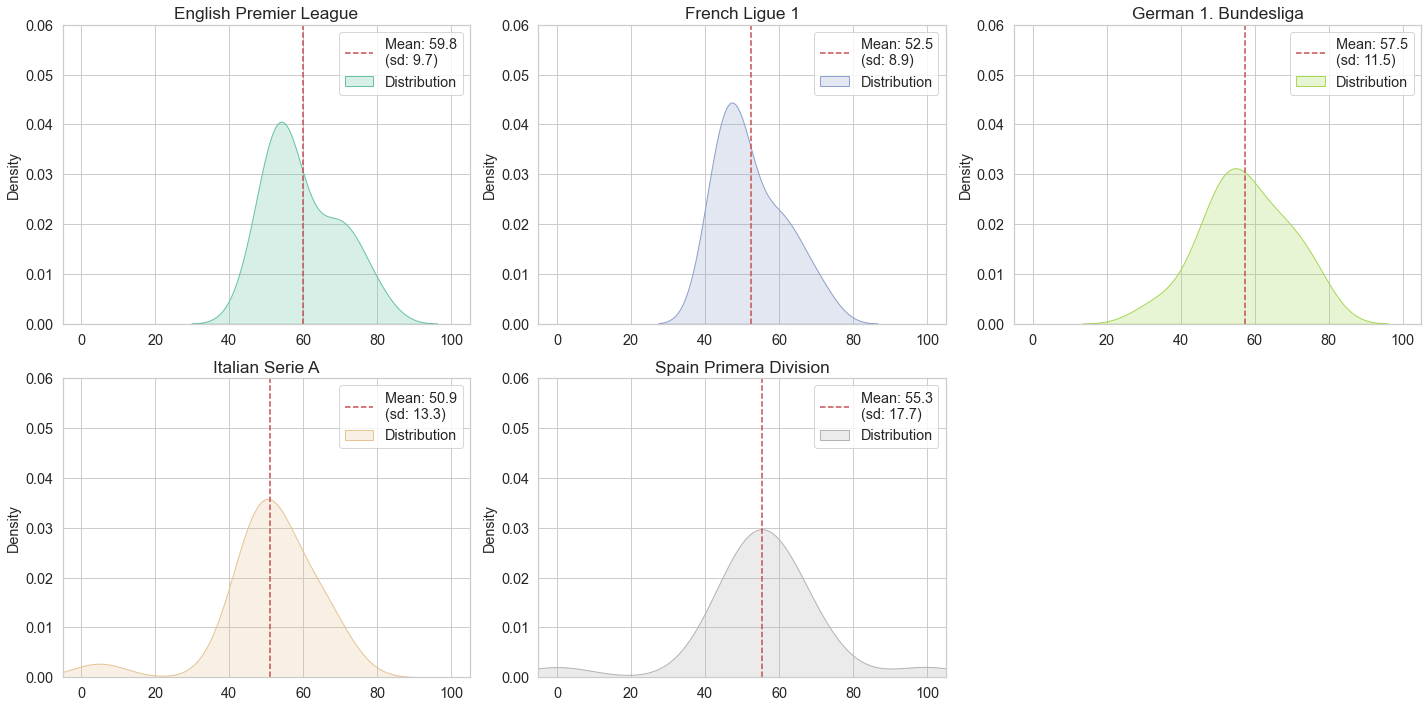

In [178]:
# Injury resistance
xmin = max(df_c_viz['Injury resistance'].min() - 10, 0)
xmax = min(df_c_viz['Injury resistance'].max() + 10, 100)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    if i == 5:
        ax.set_visible(False)
    else:
        df_league = df_c_viz[df_c_viz['league'] == leagues[i]]
        sns.kdeplot(data=df_league, 
                    x='Injury resistance',
                    color=my_palette(i), 
                    fill=my_palette(i),                     
                    label='Distribution', 
                    ax=ax)
        ax.axvline(x=df_league['Injury resistance'].mean(),
                   ls='--',
                   c='r',
                   label=f'Mean: {df_league["Injury resistance"].mean():.1f}\n(sd: {df_league["Injury resistance"].std():.1f})')
        ax.legend()
        ax.set_xlim(xmin - 5, xmax + 5)
        ax.set_ylim(0, 0.06)
        ax.set(xlabel='',title=leagues[i])
#fig.suptitle('Injury resistance, by leagues', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_injury.png', dpi=300)

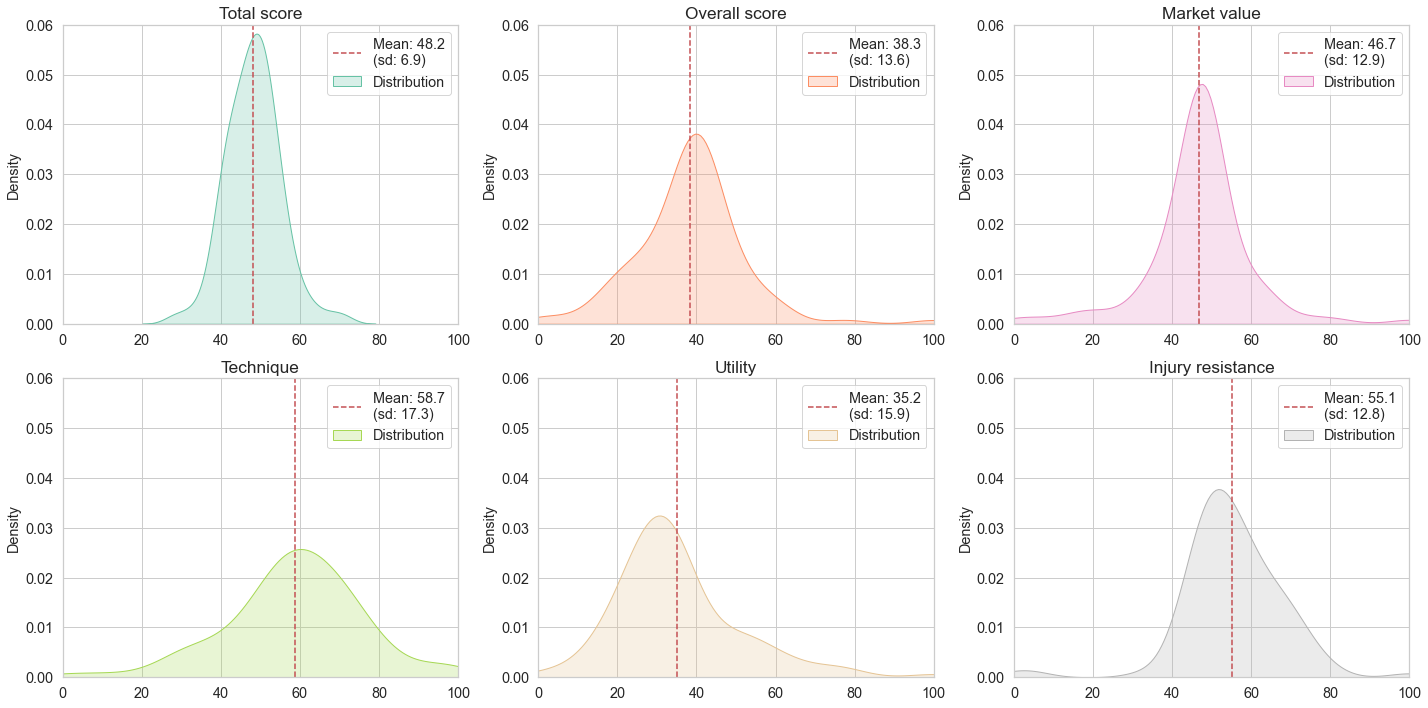

In [181]:
# distribution of all scores
all_scores = ['Total score'] + sub_scores

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
my_palette = plt.cm.get_cmap("Set2", len(all_scores))
for i, ax in enumerate(axs.ravel()):
    sns.kdeplot(data=df_c_viz, 
                x=all_scores[i],
                color=my_palette(i), 
                fill=my_palette(i),                     
                label='Distribution', 
                ax=ax)
    ax.axvline(x=df_c_viz[all_scores[i]].mean(),
               ls='--',
               c='r',
               label=f'Mean: {df_c_viz[all_scores[i]].mean():.1f}\n(sd: {df_c_viz[all_scores[i]].std():.1f})')
    ax.legend()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 0.06)
    ax.set(xlabel='',title=all_scores[i])
#fig.suptitle('Distribution of Total score and sub scores', fontsize=20)
plt.tight_layout()
fig.savefig('figures/PartC_dist_all.png', dpi=300)